# RADIS: Chunks vs. Non-chunks Performance Comparison (for Equilibrium Spectra) with examples
This notebook is meant to provide users with examples on how to compute **equilibrium** spectra using RADIS using the chunksize feature for calculating broadening, which is usually the bottleneck step.
This chunksize feature aims to provide reasonable calculation times on machines with weaker hardware, such as less RAM.

Using the chunksize feature, we basically split our database in "chunks", using those chunks to calculate the parameters important to the broadening step. This introduces a performance overhead, which can be adjusted by increasing the size of the chunks.

### Importing modules

In [16]:
import time
import numpy as np
import radis
import matplotlib.pyplot as plt
from radis import plot_diff, SpectrumFactory, calc_spectrum, get_residual, fetch_hitemp

In [17]:
# Changing the plotting config to resolve some publib library errors
radis.config["plot"]["plotlib"] = "seaborn"
radis.config["plot"]["context"] = "paper"
radis.config["plot"]["style"] = "darkgrid"

## Computing Equilibrium Spectra

In [18]:
sf = SpectrumFactory(
            wavelength_min=4000,
            wavelength_max=6000,
            cutoff=0,
            pressure=1,
            isotope="1,2",
            truncation=5,
            neighbour_lines=5,
            path_length=0.1,
            mole_fraction=1e-3,
            medium="vacuum",
            optimization=None, # No optimization strategy used
            chunksize=None, # Initialising chunksize as None for comparison
            wstep=0.001,
            verbose=False,
        )
sf.load_databank("HITEMP-CO")

Guessed that /Users/sagarchotalia/.radisdb/hitemp/CO-05_HITEMP2019.hdf5 was compatible with `vaex` engine


### Spectrum calculation with no chunksize

In [19]:
s_no_chunk_no_opt = sf.eq_spectrum(Tgas = 3000)

#### Plotting the results

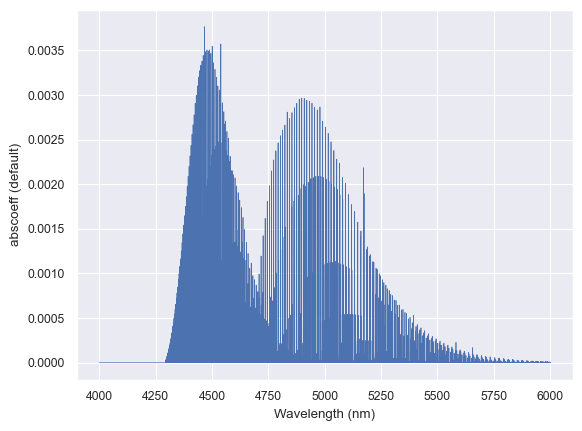

In [20]:
s_no_chunk_no_opt.plot("abscoeff")

### Now, computing the same spectrum with a chunksize

In [22]:
sf.misc["chunksize"] = 1e6 # Setting a chunksize
s_chunk_no_opt = sf.eq_spectrum(Tgas = 3000)

#### Plotting the result

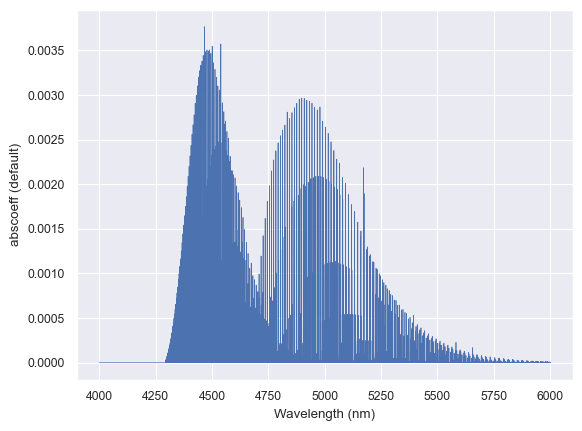

In [23]:
s_chunk_no_opt.plot("abscoeff")

As you can see, the outputs are the same. Let's take a look at the difference between the two spectra:

#### Plotting the difference and getting the residual:

/Users/sagarchotalia/radis/radis/spectrum/compare.py:990: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  plt.tight_layout()
/Users/sagarchotalia/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sagarchotalia/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sagarchotalia/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sagarchotalia/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw

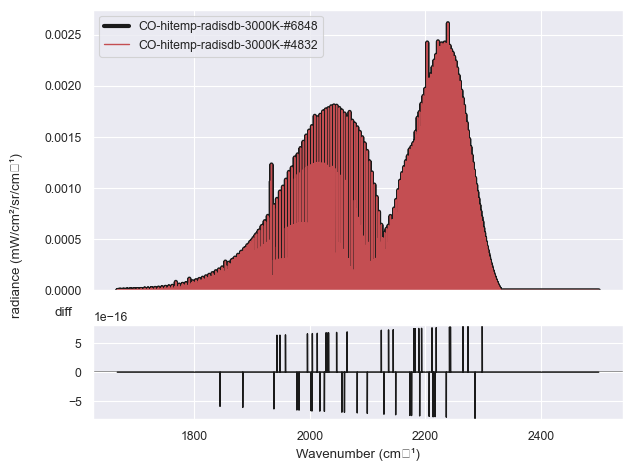

Residual between the two spectra: 7.035096655532095e-22


In [24]:
plot_diff(s_chunk_no_opt, s_no_chunk_no_opt)
res = get_residual(s_chunk_no_opt, s_no_chunk_no_opt, "abscoeff")
assert res < 1e-10
print("Residual between the two spectra: {0}".format(res))

There's a very small residual between the two spectra. Now let's have a look at the calculation times for both:

In [25]:
print("Spectrum computed without chunksize in {0} s. Number of lines = {1}".format(s_no_chunk_no_opt.get_conditions()['calculation_time'], s_no_chunk_no_opt.get_conditions()['lines_calculated']))
print("Spectrum computed with chunksize = {0} in {1} s. Number of lines = {2}".format(s_chunk_no_opt.get_conditions()['chunksize'], s_chunk_no_opt.get_conditions()['calculation_time'], s_chunk_no_opt.get_conditions()['lines_calculated']))

Spectrum computed without chunksize in 39.409446001052856 s. Number of lines = 14674
Spectrum computed with chunksize = 1000000.0 in 63.25702476501465 s. Number of lines = 14674


### Calculating the same spectrum multiple times for statistical fluctuations

In [26]:
calc_times = []
chunk_list = []
s = SpectrumFactory(
            wavelength_min=3000,
            wavelength_max=4000,
            cutoff=0, # All lines included, may increase calculation time
            pressure=1,
            molecule = "NO",
            isotope="1,2",
            truncation=5,
            neighbour_lines=5,
            path_length=0.1,
            mole_fraction=1e-3,
            medium="vacuum",
            optimization=None, # No optimization strategy used
            chunksize=None, # Initialising chunksize as None for comparison
            wstep="auto",
            verbose=False,
        )
chunksize = 1e11
# Calculating the spectrum with no chunksize, to get the baseline calculation times
s.fetch_databank("hitemp")
for i in range(5):
    s_new = s.eq_spectrum(Tgas=2000)
    chunk_list.append(s_new.get_conditions()['chunksize'])
    calc_times.append(s_new.get_conditions()['calculation_time'])

Calculating the spectrum with different chunksizes multiple times:

In [27]:
for i in range (1,10):
    for j in range(5):
        s.misc["chunksize"] = chunksize/(10**i)
        s1 = s.eq_spectrum(Tgas = 2000)
        calc_times.append(s1.get_conditions()["calculation_time"])
        chunk_list.append(s.misc["chunksize"])

### Plotting the fluctuations

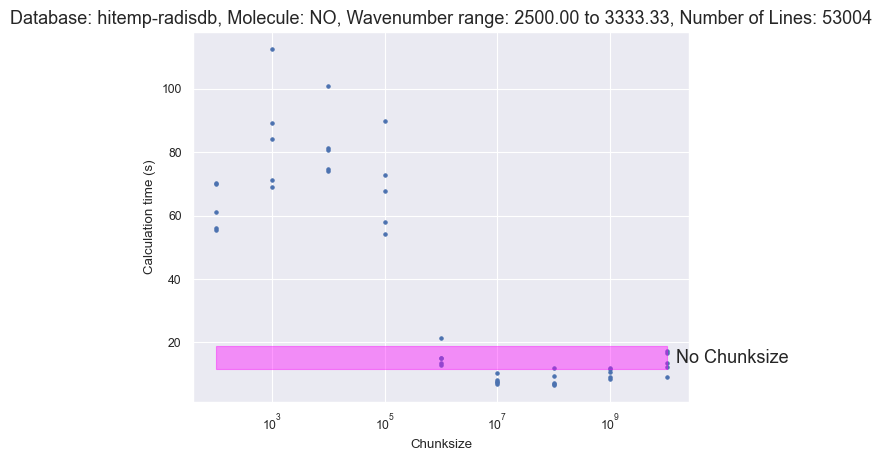

In [39]:
plt.xscale("log")
plt.scatter(chunk_list, calc_times, marker = ".")
plt.xlabel("Chunksize")
plt.ylabel("Calculation time (s)")
plt.text(1.5e10, 13.5, "No Chunksize", fontsize = 13)
plt.title("Database: {0}, Molecule: {1}, Wavenumber range: {2:.2f} to {3:.2f}, Number of Lines: {4}".format(s.params.dbformat,s.input.molecule,s.input.wavenum_min,s.input.wavenum_max,s_new.get_conditions()['lines_calculated']), fontsize = 13)
chunk_list = np.array(chunk_list, dtype=float)
plt.fill_between(chunk_list, max(calc_times[0:5]), min(calc_times[0:5]), alpha=0.4, color = "magenta")
plt.show()

The purple band that you see here is the range of times that a spectrum calculation takes with no chunksize, and the scatter plot represents the calculation times with different chunk sizes.

As you can see, the calculation time with a chunksize value reaches non-chunksize computation times after a certain value. It occupies lesser RAM in general, while providing good calculation times with an increase in the number of lines per chunk of the database.